In [1]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error #We'll be using RMSE as a metric

color_pal = sns.color_palette()#seaborn color palette

In [2]:
plt.style.use('ggplot')

In [3]:
df = pd.read_csv("/kaggle/input/hourly-energy-consumption/PJME_hourly.csv")
df = df.set_index("Datetime")
#usual practice to make DateTime column the index 
df.index = pd.to_datetime(df.index)
#convert index object data type to DateTime data type

In [4]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


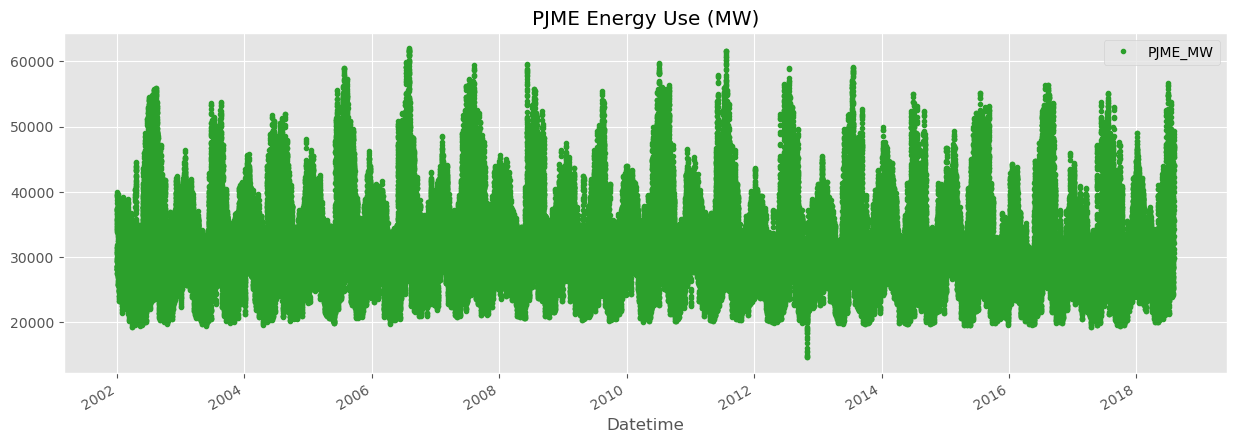

In [5]:
#visualize it 
df.plot(style='.',
       figsize = (15,5),
       color = color_pal[2],
       title = 'PJME Energy Use (MW)')
plt.show()

So, we can see our data is seasonal pattern of data which makes sense.

## Outlier analysis/removal

Between 2012 and 2014, there is some data which is lower than 20,000 MW which seems like an outlier

<Axes: ylabel='Frequency'>

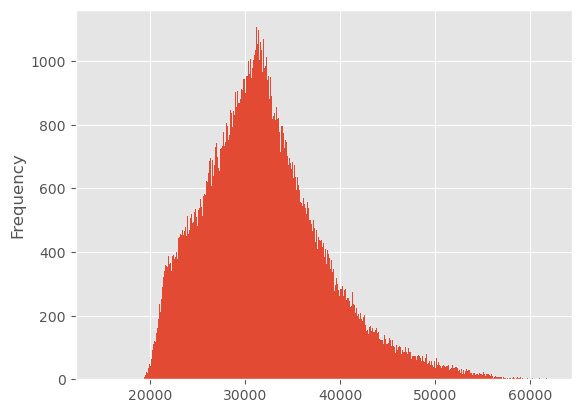

In [7]:
df['PJME_MW'].plot(kind='hist', bins=500)
#Looking at the distribution of PJME_MW
#Most of the values are from 20,000 to 50,000

<Axes: xlabel='Datetime'>

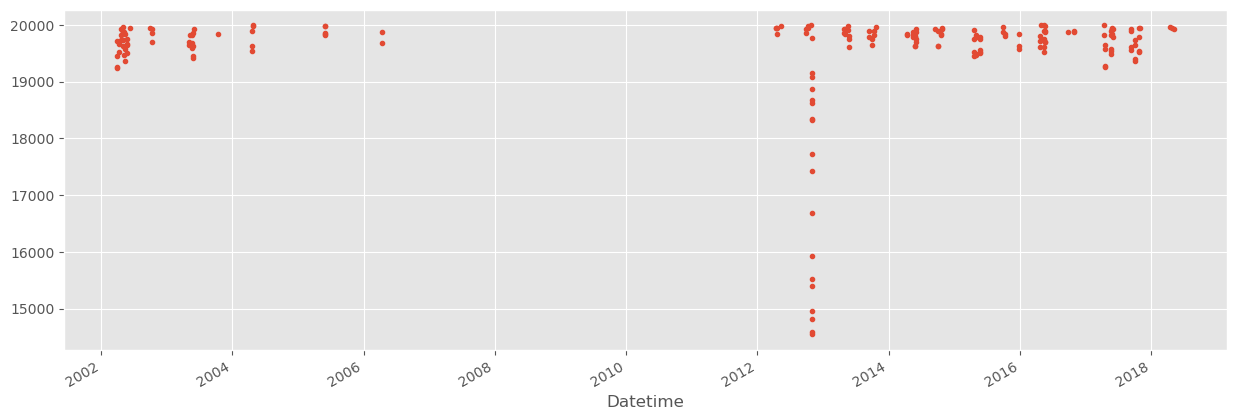

In [10]:
df.query("PJME_MW < 20_000")['PJME_MW'].plot(figsize=(15,5), style='.')

We can sense through the graph that the 19000 MW would be a better threshold for legitimate outliers

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

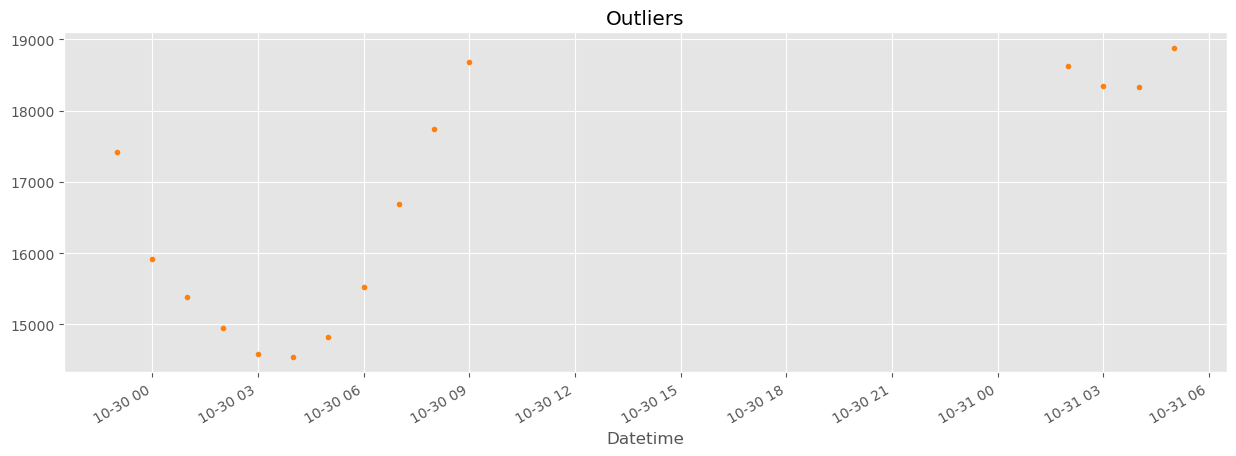

In [7]:
df.query("PJME_MW < 19_000")['PJME_MW'].plot(style='.',
                                            figsize = (15,5),
                                            color = color_pal[1],
                                            title = 'Outliers')

In [13]:
df = df.query('PJME_MW > 19_000').copy()

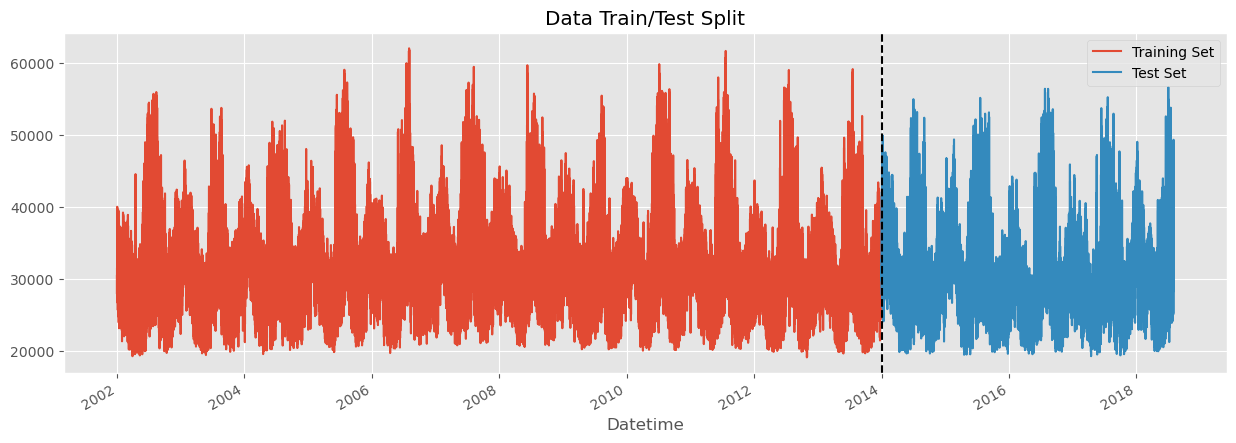

In [14]:
train = df.loc[df.index < '01-01-2014']
test = df.loc[df.index >= '01-01-2014']

fig,ax = plt.subplots(figsize = (15,5))
train.plot(ax=ax, label = 'Training set', title = 'Data Train/Test Split')
test.plot(ax=ax, label = 'Test set')
ax.axvline('01-01-2014', color='black', ls = '--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

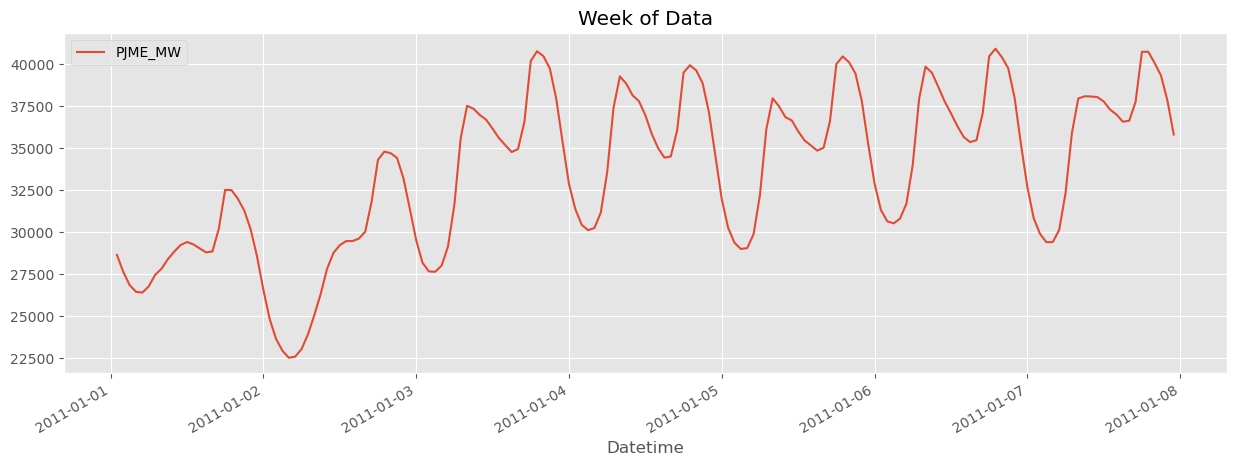

In [15]:
df.loc[(df.index > '01-01-2011') & (df.index < '01-08-2011')].plot(figsize = (15,5),
                                                                  title = 'Week of Data')
plt.show()

## Time Series Cross Validation 

In [16]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
#test size is 24*365*1 for predicting 1 year into the future
df = df.sort_index()
#index needs to be sorted otherwise time series split will not work 

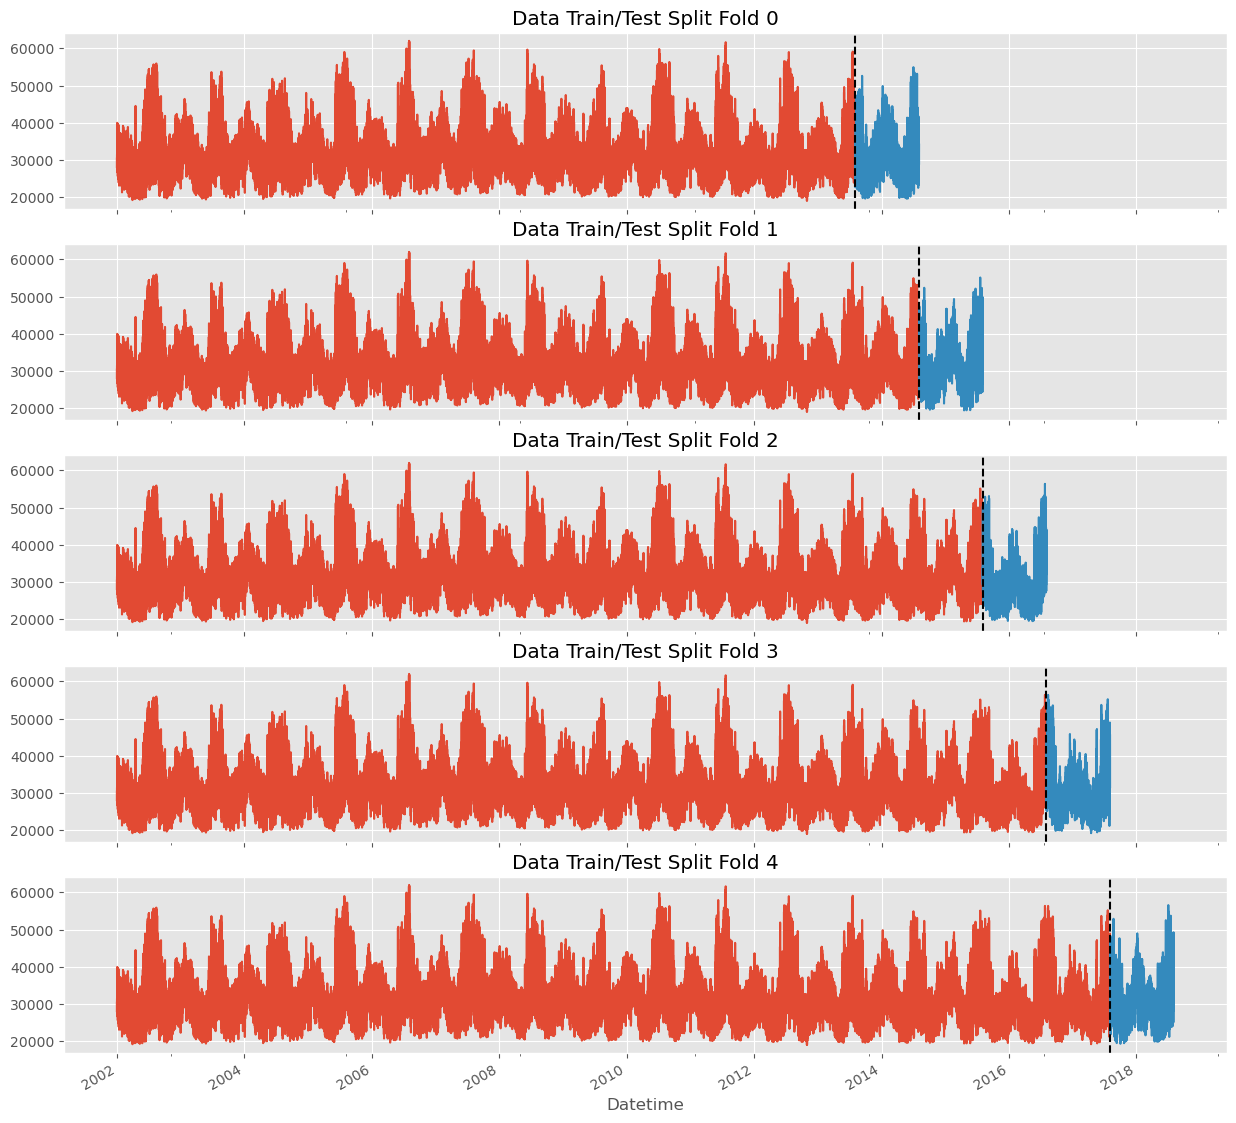

In [17]:
fig,axs = plt.subplots(5,1, figsize=(15,15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                         label='Training Set',
                         title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                        label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold+=1
plt.show()

## Creating features

*Forecasting Horizon:*  Forecasting Horizon is the length of time into the future for which the forecast are to be prepared. They can be short time forecasting horizon or long term forecasting horizon. As expected it will be a bit easier to make predictions for an hour or two into the future instead of an year or two into the future

In [18]:
#features about the hour of the day, day of the week type things
def create_features(df):
    df=df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekoftheyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

## Lag features

Lag features are created because it's considered that old values that have occured in the past can influence or contain some sort of information about the future.

In [19]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df
#364 becuase it's divisible by 7

In [20]:
df = add_lags(df)

In [21]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekoftheyear', 'lag1', 'lag2', 'lag3'],
      dtype='object')

## Train using Cross validation

In [22]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    valid = df.iloc[val_idx]
    
    train = create_features(train)
    test = create_features(test)
    
    train = add_lags(train)
    test = add_lags(test)
    FEATURES = ['dayofyear','hour','dayofweek','quarter','month', 'year','lag1','lag2','lag3']
    target = 'PJME_MW'
    
    X_train = train[FEATURES]
    y_train = train[target]
    
    X_test = test[FEATURES]
    y_test = test[target]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster = 'gbtree',
                          n_estimators=1000,
                          early_stopping_rounds=50,
                          objective='reg:linear',
                          max_depth=3,
                          learning_rate=0.01)
    reg.fit(X_train,y_train,
           eval_set=[(X_train,y_train), (X_test,y_test)],
           verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test,y_pred)) #scoring the model on rmse
    scores.append(score)

[18:40:17] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.50147	validation_1-rmse:31473.71617
[100]	validation_0-rmse:12532.10915	validation_1-rmse:12444.35235
[200]	validation_0-rmse:5739.78666	validation_1-rmse:6523.43662
[300]	validation_0-rmse:3868.29390	validation_1-rmse:4966.61850
[400]	validation_0-rmse:3428.85875	validation_1-rmse:4563.25678
[500]	validation_0-rmse:3313.95004	validation_1-rmse:4429.05648
[600]	validation_0-rmse:3257.51011	validation_1-rmse:4382.93298
[700]	validation_0-rmse:3217.49502	validation_1-rmse:4347.25762
[800]	validation_0-rmse:3183.53053	validation_1-rmse:4307.29619
[900]	validation_0-rmse:3155.13209	validation_1-rmse:4280.25304
[999]	validation_0-rmse:3122.54432	validation_1-rmse:4264.43183
[18:41:01] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32672.16154	validation_1-rmse:3147

In [23]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 4371.3663
Fold scores:[4264.4318258802505, 4265.5980971188355, 4269.137718711557, 4524.687060957395, 4532.976596549945]


## Predicting the future

In [24]:
df = create_features(df)

X_all = df[FEATURES]
y_all = df[target]

reg = xgb.XGBRegressor(base_score=0.5,
                      booster = 'gbtree',
                      n_estimators=500,
                      objective='reg:linear',
                      max_depth=3,
                      learning_rate=0.01)
reg.fit(X_all, y_all, 
       eval_set=[(X_all,y_all)],
       verbose = 100)

[18:49:06] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.88753
[100]	validation_0-rmse:12426.44700
[200]	validation_0-rmse:5752.69704
[300]	validation_0-rmse:3970.08787
[400]	validation_0-rmse:3569.37848
[499]	validation_0-rmse:3454.55122


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [25]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [26]:
future = pd.date_range('2018-08-03','2019-08-01', freq = '1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [27]:
future_w_features = df_and_future.query('isFuture').copy()

## Predict the future

In [28]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

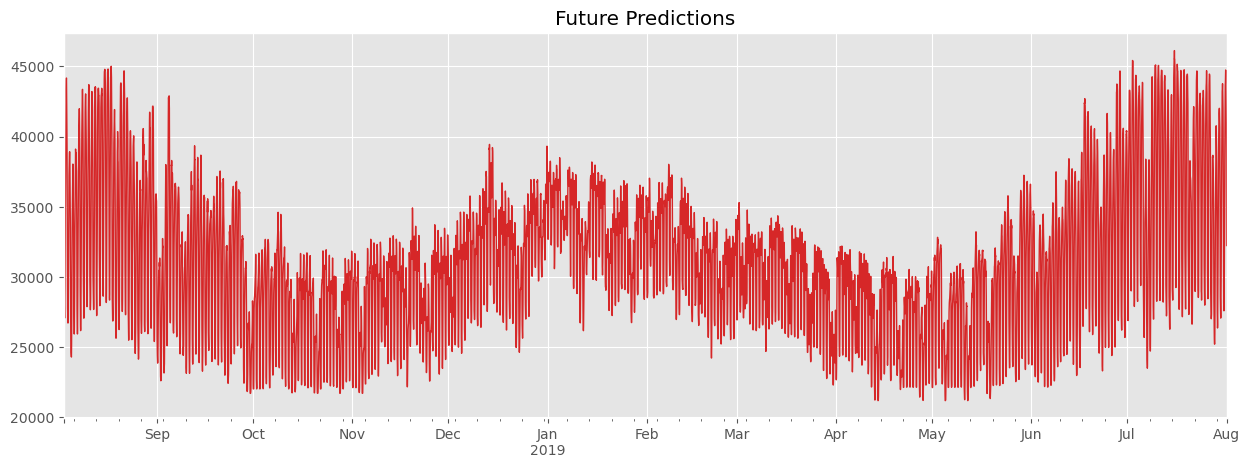

In [29]:
future_w_features['pred'].plot(figsize=(15,5),
                              color=color_pal[3],
                              ms=1,
                              lw=1,
                              title='Future Predictions')
plt.show()